---
title: Graph Cleaning
date-format: long
date-modified: last-modified
lang: en
language:
  title-block-modified: "Last update"
---


Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer

See the [guide](https://cityseer.benchmarkurbanism.com/guide) for a preamble.

Please also see the [`graph corrections`](https://cityseer.benchmarkurbanism.com/guide#graph-corrections) guide for an alternative approach.


## Downloading data

This example will make use of OSM data downloaded from the [OSM API](https://wiki.openstreetmap.org/wiki/API). To keep things interesting, let's pick London Soho, which will be buffered and cleaned for a 1,250m radius.


In [2]:
from shapely import geometry
import utm

from cityseer.tools import graphs, plot, io

# Let's download data within a 1,250m buffer around London Soho:
lng, lat = -0.13396079424572427, 51.51371088849723
# lng, lat = 2.166981, 41.389526 -- Barcelona - which is a complex case
buffer = 1250
# creates a WGS shapely polygon
poly_wgs, _ = io.buffered_point_poly(lng, lat, buffer)
# use a WGS shapely polygon to download information from OSM
# this version will not simplify
G_raw = io.osm_graph_from_poly(poly_wgs, simplify=False)
# whereas this version does simplify
G_utm = io.osm_graph_from_poly(poly_wgs)

# select extents for clipping the plotting extents
easting, northing = utm.from_latlon(lat, lng)[:2]
buff = geometry.Point(easting, northing).buffer(1000)
min_x, min_y, max_x, max_y = buff.bounds


# reusable plot function
def simple_plot(_G, plot_geoms=True):
    # plot using the selected extents
    plot.plot_nx(
        _G,
        labels=False,
        plot_geoms=plot_geoms,
        node_size=4,
        edge_width=1,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=(6, 6),
        dpi=150,
    )

INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 14453/14453 [00:00<00:00, 520645.14it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 15749/15749 [00:00<00:00, 1314836.95it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 15749/15749 [00:00<00:00, 101549.61it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 14453/14453 [00:01<00:00, 9791.34it/s] 
INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 14453/14453 [00:00<00:00, 608447.93it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 15749/15749 [00:00<00:00, 1166079.89it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 15749/15749 [00:00

The automated graph cleaning may give satisfactory results depending on the intended end-use. See the steps following beneath for an example of how to manually clean the graph where additional control is preferred.


INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges


The graph before simplification.


100%|██████████| 7514/7514 [00:00<00:00, 14285.58it/s]


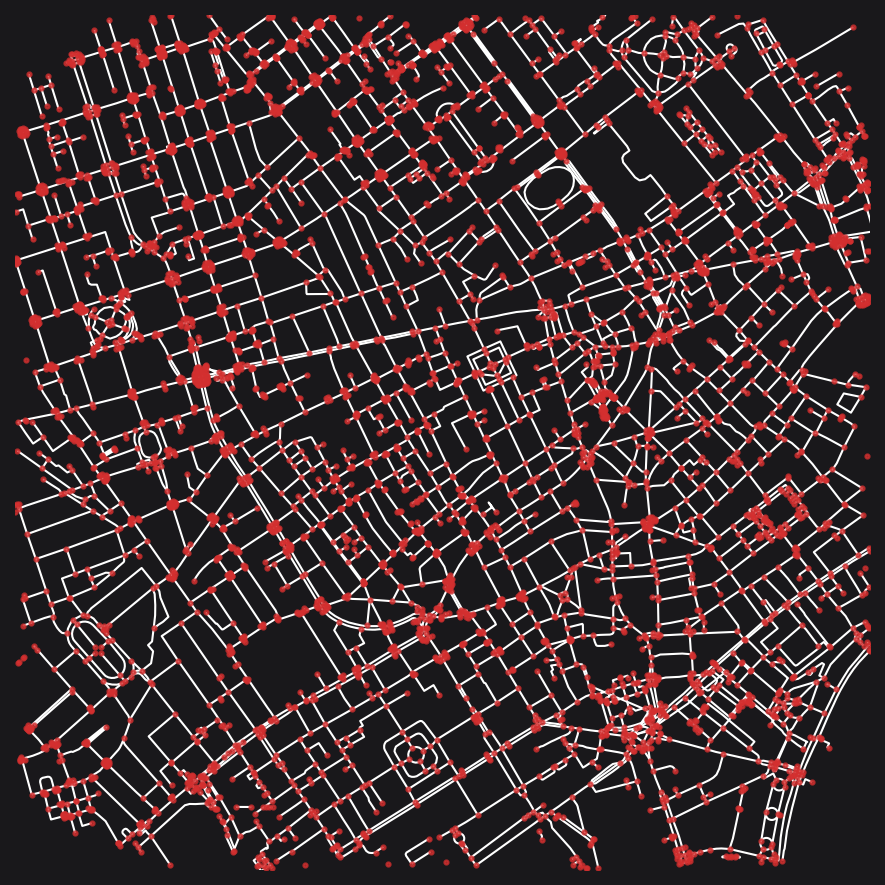

INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges


The graph after simplification


100%|██████████| 2987/2987 [00:00<00:00, 18663.26it/s]


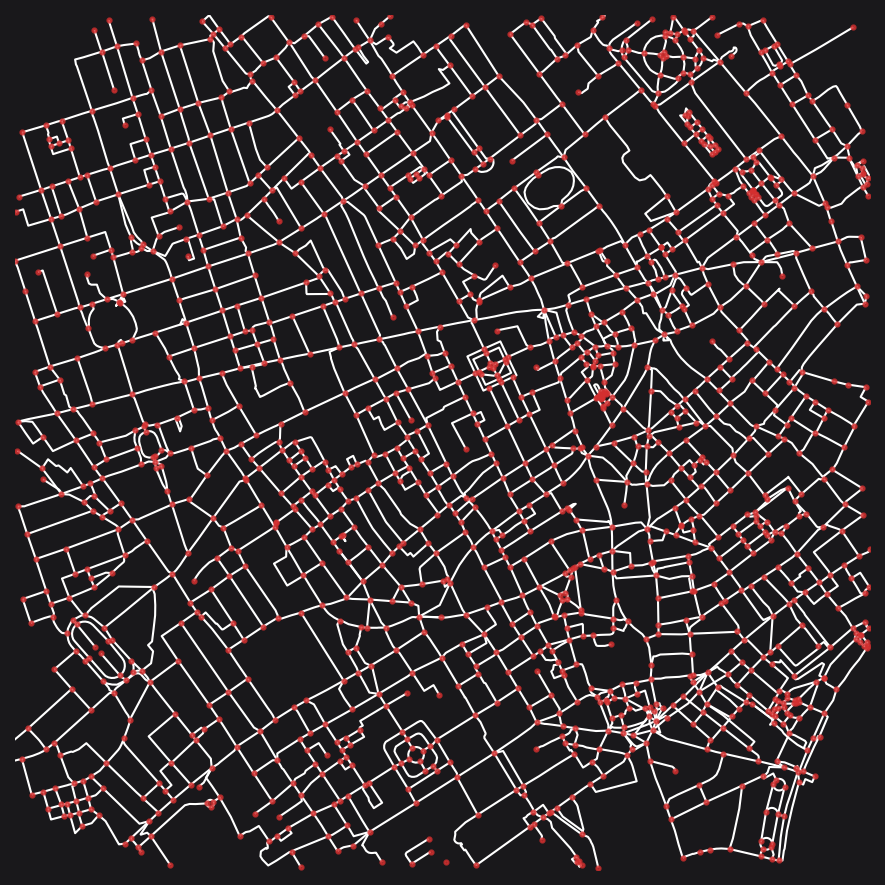

In [3]:
print("The graph before simplification.")
simple_plot(G_raw, plot_geoms=True)

print("The graph after simplification")
simple_plot(G_utm, plot_geoms=True)

## Manual cleaning

The automated simplification uses a number of steps and should generally give a solid starting point for further manual cleaning.

It is also possible to clean the network with an entirely manual sequence of steps if you need greater control. The following is the steps followed by the automatic cleaning routine. You can adapt this to work for context specific considerations such as which OSM road types to clean and what distances to use.


INFO:cityseer.tools.graphs:Removing dangling nodes.
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 5867/5867 [00:00<00:00, 915748.05it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 7304/7304 [00:00<00:00, 616526.39it/s]
INFO:cityseer.tools.graphs:Splitting opposing edges.
100%|██████████| 5867/5867 [00:00<00:00, 12495.85it/s]
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
100%|██████████| 7389/7389 [00:00<00:00, 83607.73it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 7316/7316 [00:00<00:00, 764729.30it/s]
INFO:cityseer.tools.graphs:Splitting opposing edges.
100%|██████████| 5867/5867 [00:00<00:00, 18660.09it/s]
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
100%|██████████| 7359/7359 [00:00<00:00, 74428.71it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|███

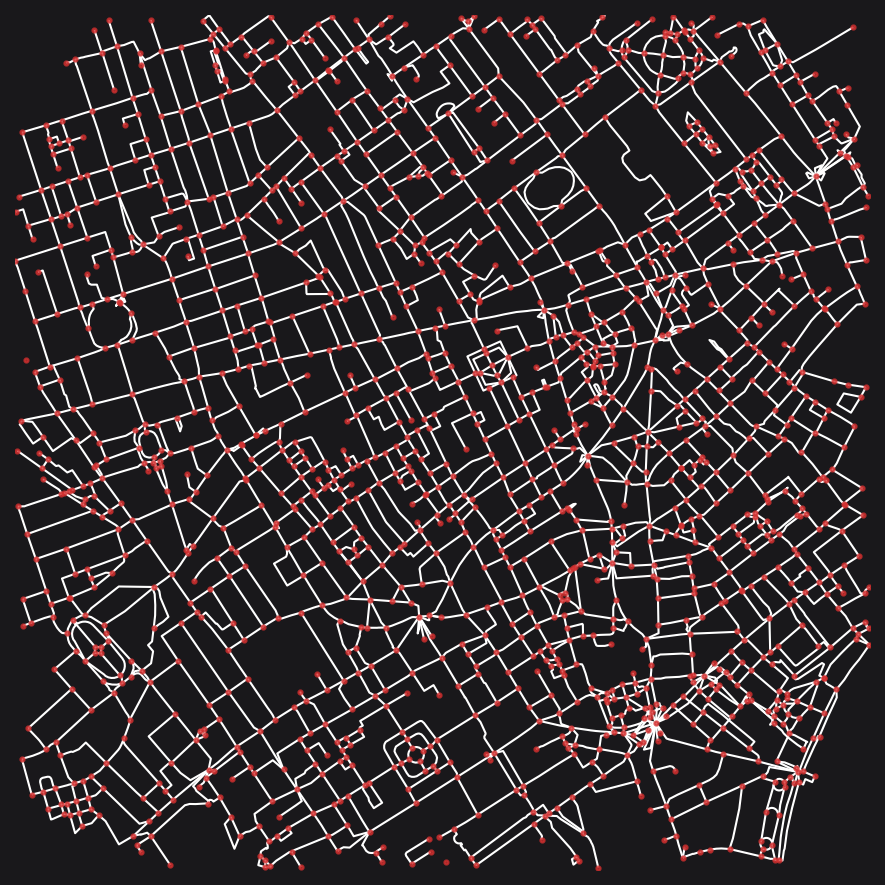

In [4]:
# remove disconnected components
graph_crs = graphs.nx_remove_dangling_nodes(G_raw, despine=0, remove_disconnected=100)
# clean by highway types - leave motorway and trunk as is
for dist, tags, simplify_line_angles in (
    (20, ["primary"], 45),  # , "primary_link"
    (18, ["primary", "secondary"], 45),  # , "secondary_link"
    (16, ["primary", "secondary", "tertiary"], 45),  # , "tertiary_link"
):
    graph_crs = graphs.nx_split_opposing_geoms(
        graph_crs,
        buffer_dist=dist,
        squash_nodes=True,
        osm_hwy_target_tags=tags,
        centroid_by_itx=True,
        prioritise_by_hwy_tag=True,
        simplify_line_angles=simplify_line_angles,
    )
for dist, tags, simplify_line_angles in (
    (20, ["primary"], 95),  # , "primary_link"
    (18, ["primary", "secondary"], 95),  # , "secondary_link"
    (16, ["primary", "secondary", "tertiary"], 95),  # , "tertiary_link"
):
    graph_crs = graphs.nx_consolidate_nodes(
        graph_crs,
        buffer_dist=dist,
        crawl=True,
        osm_hwy_target_tags=tags,
        centroid_by_itx=True,
        prioritise_by_hwy_tag=True,
        simplify_line_angles=simplify_line_angles,
    )
    graph_crs = graphs.nx_remove_filler_nodes(graph_crs)
# do smaller scale cleaning
tags = [
    "residential",
    "service",
    "cycleway",
    "footway",
    "path",
    "living_street",
]
dists = [5, 10]
simplify_angles = 95
#
for dist in dists:
    graph_crs = graphs.nx_split_opposing_geoms(
        graph_crs,
        buffer_dist=dist,
        squash_nodes=True,
        centroid_by_itx=True,
        osm_hwy_target_tags=tags,
        simplify_line_angles=simplify_angles,
    )
    graph_crs = graphs.nx_consolidate_nodes(
        graph_crs,
        buffer_dist=dist,
        crawl=True,
        centroid_by_itx=True,
        osm_hwy_target_tags=tags,
        prioritise_by_hwy_tag=True,
        simplify_line_angles=simplify_angles,
    )
graph_crs = graphs.nx_remove_filler_nodes(graph_crs)
# snap gapped endings - don't clean danglers before this
graph_crs = graphs.nx_snap_gapped_endings(
    graph_crs,
    buffer_dist=20,
    # not main roads
    osm_hwy_target_tags=[
        "residential",
        "service",
        "cycleway",
        "busway",
        "footway",
        "living_street",
    ],
)
# snap gapped endings / roads - don't clean danglers before this
# look for degree 1 dead-ends and link to nearby edges
graph_crs = graphs.nx_split_opposing_geoms(
    graph_crs,
    buffer_dist=25,
    min_node_degree=1,
    max_node_degree=1,
    squash_nodes=False,
)
# remove longer danglers
graph_crs = graphs.nx_remove_dangling_nodes(graph_crs, despine=20)

simple_plot(graph_crs, plot_geoms=True)